In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/MyDrive/Graph_Neural_Network')

In [ ]:
!pip install torch_geometric==2.5.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.2/64.2 kB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import torch
from torch_geometric.data import Data
from torch_geometric.nn import TAGConv
import torch.nn.functional as F
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, matthews_corrcoef
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import kneighbors_graph

In [ ]:
# 1. Load data
df = pd.read_csv("./data/ethereum_transactional_dataset/transaction_dataset.csv")

# Drop rows with missing labels
df = df.dropna(subset=['FLAG'])
df['FLAG'] = df['FLAG'].astype(int)

# Select numeric feature columns
feature_cols = df.select_dtypes(include=[np.number]).columns.tolist()
feature_cols = [c for c in feature_cols if c not in ['Index', 'FLAG']]
X = df[feature_cols].fillna(0).values
y = df['FLAG'].values


In [ ]:
# 2. Feature Standardization
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# 3. Construct Graph via kNN
# Build adjacency structure based on feature similarity
k = 8
A = kneighbors_graph(X_scaled, k, mode='connectivity', include_self=False)
edge_index = torch.tensor(np.array(A.nonzero()), dtype=torch.long)

# 4. Prepare PyG Data Object
x = torch.tensor(X_scaled, dtype=torch.float)
y = torch.tensor(y, dtype=torch.float)
data = Data(x=x, edge_index=edge_index, y=y)


In [ ]:
# 5. Train/Test Split
idx = np.arange(len(y))
train_idx, test_idx = train_test_split(idx, test_size=0.2, stratify=y, random_state=42)
data.train_idx = torch.tensor(train_idx, dtype=torch.long)
data.test_idx = torch.tensor(test_idx, dtype=torch.long)

In [ ]:
# 6. Define TAGCN Model
class TAGCNModel(torch.nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, K=3):
        super().__init__()
        self.conv1 = TAGConv(in_dim, hidden_dim, K)
        self.conv2 = TAGConv(hidden_dim, out_dim, K)
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.conv2(h, edge_index)
        return h


In [ ]:
# 7. Training Process
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TAGCNModel(x.shape[1], 128, 1).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=1e-5)
criterion = torch.nn.BCEWithLogitsLoss()

data = data.to(device)

for epoch in range(100):
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index).squeeze()
    loss = criterion(out[data.train_idx], data.y[data.train_idx])
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f"Epoch {epoch}: Loss = {loss.item():.4f}")


Epoch 0: Loss = 0.6652
Epoch 10: Loss = 0.1596
Epoch 20: Loss = 0.0933
Epoch 30: Loss = 0.0655
Epoch 40: Loss = 0.0524
Epoch 50: Loss = 0.0448
Epoch 60: Loss = 0.0395
Epoch 70: Loss = 0.0354
Epoch 80: Loss = 0.0320
Epoch 90: Loss = 0.0290


In [ ]:
# 8. Evaluation
model.eval()
with torch.no_grad():
    preds = torch.sigmoid(model(data.x, data.edge_index)).squeeze().cpu().numpy()
    y_pred = (preds[data.test_idx] > 0.5).astype(int)
    y_true = data.y[data.test_idx].cpu().numpy().astype(int)

acc = accuracy_score(y_true, y_pred)
prec = precision_score(y_true, y_pred)
rec = recall_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred)
mcc = matthews_corrcoef(y_true, y_pred)

print("\n===== Ethereum Fraud Detection Results =====")
print(f"Accuracy:  {acc:.4f}")
print(f"Precision: {prec:.4f}")
print(f"Recall:    {rec:.4f}")
print(f"F1-score:  {f1:.4f}")
print(f"MCC:       {mcc:.4f}")


===== Ethereum Fraud Detection Results =====
Accuracy:  0.9863
Precision: 0.9723
Recall:    0.9656
F1-score:  0.9689
MCC:       0.9601


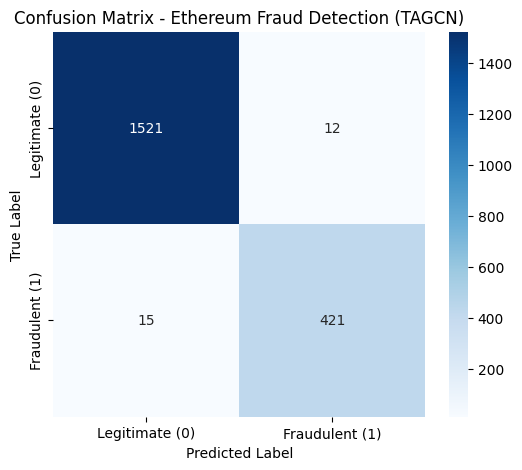


Confusion Matrix:
TP = 421, FN = 15, FP = 12, TN = 1521
Sensitivity (Recall): 0.9656
Specificity: 0.9922


In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 9. Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
cm_labels = ["Legitimate (0)", "Fraudulent (1)"]

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=cm_labels, yticklabels=cm_labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix - Ethereum Fraud Detection (TAGCN)")
plt.show()

# 打印具体数值
tn, fp, fn, tp = cm.ravel()
print("\nConfusion Matrix:")
print(f"TP = {tp}, FN = {fn}, FP = {fp}, TN = {tn}")
print(f"Sensitivity (Recall): {tp / (tp + fn):.4f}")
print(f"Specificity: {tn / (tn + fp):.4f}")